In [2]:
%pip install -q -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


## Get Data

In [3]:
import requests
import os
from urllib.parse import urljoin
import base64
import json

def download_github_csvs(repo_url="https://github.com/mitchg10/Textbook-Samples.git", output_dir="data"):
    """
    Download all CSV files from a GitHub repository.

    Parameters:
    repo_url (str): URL of the GitHub repository
    output_dir (str): Local directory to save the CSV files

    Returns:
    list: List of downloaded file paths
    """
    # Convert github.com URL to api.github.com
    api_base = "https://api.github.com/repos/"
    repo_path = repo_url.replace("https://github.com/", "").replace(".git", "")
    api_url = f"{api_base}{repo_path}/contents"

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    downloaded_files = []

    try:
        # Get repository contents
        response = requests.get(api_url)
        response.raise_for_status()
        contents = response.json()

        # Filter for CSV files and download them
        for item in contents:
            if item['name'].lower().endswith('.csv'):
                # Get file content
                file_response = requests.get(item['download_url'])
                file_response.raise_for_status()

                # Save file locally
                file_path = os.path.join(output_dir, item['name'])
                with open(file_path, 'wb') as f:
                    f.write(file_response.content)

                downloaded_files.append(file_path)
                print(f"Downloaded: {item['name']}")

    except requests.exceptions.RequestException as e:
        print(f"Error downloading files: {str(e)}")
        return []

    except Exception as e:
        print(f"Unexpected error: {str(e)}")
        return []

    return downloaded_files

In [4]:
# Get the csv files
downloaded_files = download_github_csvs()

Downloaded: comparative_languages.csv
Downloaded: computer_organization_i.csv
Downloaded: computer_organization_ii.csv
Downloaded: computer_systems.csv
Downloaded: data_structures_and_algorithms.csv
Downloaded: intro_software_design.csv
Downloaded: problem_solving.csv
Downloaded: professionalism_computing.csv
Downloaded: software_design_and_data_structures.csv


## Load Data

In [5]:
import os
import pandas as pd

def load_data(directory):
    data = []
    for filename in os.listdir(directory):
        print(f"Loading data from {filename}")
        df = pd.read_csv(os.path.join(directory, filename))
        df = df[df['Example'].notna() & (df['Example'] != '[]')]  # Remove empty examples
        df['Codes'] = df['Codes'].apply(lambda x: x.split(','))  # Split multi-label codes
        data.append(df)
    return pd.concat(data, ignore_index=True)

In [8]:
# Load data
df = load_data('./data/')
print(f"\nData shape: {df.shape}\n")

Loading data from data_structures_and_algorithms.csv
Loading data from software_design_and_data_structures.csv
Loading data from computer_systems.csv
Loading data from professionalism_computing.csv
Loading data from intro_software_design.csv
Loading data from computer_organization_i.csv
Loading data from comparative_languages.csv
Loading data from computer_organization_ii.csv
Loading data from problem_solving.csv

Data shape: (9000, 6)



In [ ]:
# Get the number of unique labels
labels = set()
for codes in df['Codes']:
    labels.update(codes)
num_labels = len(labels)
print(f"Number of unique labels: {num_labels}")

Number of unique labels: 10


In [ ]:
passages = []
passage_labels = []

# Separate examples and labels so that each example has a single label
for i, row in df.iterrows():
    example = row['Example']
    for label in row['Codes']:
        passages.append(example)
        passage_labels.append(label)

In [ ]:
# Print an example
print(f'Example: {passages[0]}')
print(f'Label: {passage_labels[0]}')

Example: Data analysis in computing not only requires proficient technical skills but also a thorough understanding of ethical implications. For instance, when analyzing user data to enhance software features, engineers must adhere to privacy laws and ethical guidelines to protect user information. This involves implementing robust security measures and transparent data handling practices. Moreover, the use of tools like Python's pandas library for data manipulation or R for statistical analysis should be guided by best professional standards to ensure accuracy and reliability in results.
Label: PRAC


In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

# Transform labels using MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mlb.fit(df['Codes'])

# Split data
passages_train, passages_test, labels_train, labels_test = train_test_split(
    df['Example'].values,
    mlb.transform([label for label in df['Codes']]),
    test_size=0.2,
    random_state=42
)

passages_train, passages_dev, labels_train, labels_dev = train_test_split(
    passages_train,
    labels_train,
    test_size=0.1,
    random_state=42
)

print(f'Training examples: {len(passages_train)}')
print(f'Dev examples: {len(passages_dev)}')
print(f'Test examples: {len(passages_test)}')

Training examples: 6480
Dev examples: 720
Test examples: 1800


In [ ]:
# Print a sample
print(f"Example: {passages_train[12]}")
print(f"Label: {labels_train[12]}")

Example: Figure 3 illustrates a binary search tree (BST) used for efficient data retrieval operations such as insertion, deletion, and searching. In practical applications, BSTs are commonly implemented in databases to maintain an ordered list of records, optimizing access times through logarithmic complexity operations. To ensure balanced performance, self-balancing techniques like AVL trees or red-black trees are often employed. For instance, a software system managing real-time stock market data might use a balanced BST to quickly update and query price changes. This implementation not only adheres to professional standards for efficient data management but also demonstrates best practices in software design for scalable and maintainable systems.
Label: [0 0 0 0 0 0 0 1 1 0]


## Preprocessing

In [ ]:
BATCH_SIZE = 64

In [ ]:
from transformers import AutoTokenizer

# Initialize tokenizer - using BERT base
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        labels = self.labels[idx].astype(float)  # Convert to float for BCE loss

        # Tokenize the text
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.FloatTensor(labels)
        }

In [ ]:
def create_dataloaders(train_texts, train_labels,
                      val_texts, val_labels,
                      test_texts, test_labels,
                      tokenizer, batch_size=16):
    """
    Create DataLoader objects for train, validation, and test sets
    """
    # Create datasets
    train_dataset = TextDataset(train_texts, train_labels, tokenizer)
    val_dataset = TextDataset(val_texts, val_labels, tokenizer)
    test_dataset = TextDataset(test_texts, test_labels, tokenizer)

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2
    )

    return train_loader, val_loader, test_loader

In [ ]:
# Calculate class weights for balanced loss
def calculate_class_weights(labels):
    """
    Calculate class weights for imbalanced dataset
    """
    pos_counts = np.sum(labels, axis=0)
    neg_counts = len(labels) - pos_counts
    pos_weights = neg_counts / pos_counts  # ratio of negative to positive samples
    return torch.FloatTensor(pos_weights)

In [ ]:
# Create the dataloaders
train_loader, val_loader, test_loader = create_dataloaders(
    passages_train, labels_train,
    passages_dev, labels_dev,
    passages_test, labels_test,
    tokenizer, BATCH_SIZE
)

In [ ]:
# Calculate class weights for loss function
class_weights = calculate_class_weights(labels_train)

In [ ]:
# Print some statistics about the data
print(f"Batch size: {BATCH_SIZE}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")

# Check the shape of a batch
batch = next(iter(train_loader))
print("\nBatch shapes:")
for k, v in batch.items():
    print(f"{k}: {v.shape}")

# Print class weights
print("\nClass weights:")
print(class_weights)

Batch size: 64
Number of training batches: 102
Number of validation batches: 12
Number of test batches: 29

Batch shapes:
input_ids: torch.Size([64, 512])
attention_mask: torch.Size([64, 512])
labels: torch.Size([64, 10])

Class weights:
tensor([1.8609, 5.1132, 4.8326, 7.3721, 5.4350, 5.5257, 7.0397, 3.0099, 3.1806,
        3.9503])


In [ ]:
# Analyze label distribution
label_names = mlb.classes_
label_counts = labels_train.sum(axis=0)
label_distribution = pd.DataFrame({
    'Label': label_names,
    'Count': label_counts,
    'Percentage': (label_counts / len(labels_train)) * 100,
    'Weight': class_weights.numpy()
})

print("Label Distribution:")
print(label_distribution.sort_values('Count', ascending=False))

# Calculate average labels per example
avg_labels = np.mean(labels_train.sum(axis=1))
print(f"\nAverage labels per example: {avg_labels:.2f}")

Label Distribution:
   Label  Count  Percentage    Weight
0    CON   2265   34.953704  1.860927
7   PRAC   1616   24.938272  3.009901
8    PRO   1550   23.919753  3.180645
9    UNC   1309   20.200617  3.950344
2    ETH   1111   17.145062  4.832583
1   EPIS   1060   16.358025  5.113207
4  INTER   1007   15.540123  5.434955
5   MATH    993   15.324074  5.525680
6   META    806   12.438272  7.039702
3    HIS    774   11.944444  7.372093

Average labels per example: 1.93


## Model setup

In [ ]:
import torch
import torch.nn as nn
from transformers import AutoModel, AutoConfig
from torch.nn.utils.parametrizations import weight_norm
from torch.optim.lr_scheduler import CyclicLR
from torch.nn import functional as F

In [ ]:
class AttentionPooling(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.attention = nn.Linear(hidden_size, 1)

    def forward(self, hidden_states, attention_mask):
        # Convert attention mask to float for masked_fill
        attention_weights = self.attention(hidden_states).squeeze(-1)
        attention_weights = attention_weights.masked_fill(~attention_mask.bool(), float('-inf'))
        attention_weights = F.softmax(attention_weights, dim=1)
        return torch.bmm(attention_weights.unsqueeze(1), hidden_states).squeeze(1)

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha  # Class weights if needed

    def forward(self, inputs, targets):
        ce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_term = (1 - pt) ** self.gamma

        if self.alpha is not None:
            alpha_t = self.alpha[targets.data.view(-1).long()].view_as(targets)
            focal_term = alpha_t * focal_term

        return (focal_term * ce_loss).mean()

In [ ]:
class CombinedBERTClassifier(nn.Module):
    def __init__(self, model_name='bert-base-uncased', num_labels=10):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.attention_pooler = AttentionPooling(self.bert.config.hidden_size)

        # Multiple dropout layers
        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.2)
        self.dropout3 = nn.Dropout(0.3)

        self.classifier = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, self.bert.config.hidden_size),
            nn.LayerNorm(self.bert.config.hidden_size),
            self.dropout1,
            nn.ReLU(),
            nn.Linear(self.bert.config.hidden_size, self.bert.config.hidden_size // 2),
            nn.LayerNorm(self.bert.config.hidden_size // 2),
            self.dropout2,
            nn.ReLU(),
            self.dropout3,
            nn.Linear(self.bert.config.hidden_size // 2, num_labels)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = self.attention_pooler(outputs.last_hidden_state, attention_mask)
        return self.classifier(pooled)

In [ ]:
# Initialize model
model = CombinedBERTClassifier(num_labels=len(label_names))

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

## Training

In [ ]:
# Clear GPU cache
torch.cuda.empty_cache()

In [ ]:
from tqdm import tqdm
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json

In [ ]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0, maximize=True):
        self.patience = patience
        self.min_delta = min_delta
        self.maximize = maximize
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, score):
        if self.best_score is None:
            self.best_score = score
            return False

        if self.maximize:
            if score < self.best_score + self.min_delta:
                self.counter += 1
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.counter = 0
        else:
            if score > self.best_score - self.min_delta:
                self.counter += 1
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.counter = 0

        return self.early_stop

In [ ]:
class ThresholdOptimizer:
    def __init__(self, num_labels, initial_thresholds):
        self.num_labels = num_labels
        self.current_thresholds = initial_thresholds
        self.min_threshold = 0.3
        self.max_threshold = 0.9
        self.steps = 100

    def adjust_thresholds(self, probs, labels):
        best_thresholds = self.current_thresholds.copy()

        for i in range(self.num_labels):
            best_f1 = 0
            for threshold in np.linspace(self.min_threshold, self.max_threshold, self.steps):
                preds = (probs[:, i] >= threshold).astype(int)
                f1 = f1_score(labels[:, i], preds)

                if f1 > best_f1:
                    best_f1 = f1
                    best_thresholds[i] = threshold

        self.current_thresholds = best_thresholds
        return best_thresholds

In [ ]:
def create_optimized_training(model, train_loader, val_loader, num_epochs=10):
    # Initialize components
    criterion = FocalLoss(gamma=2.0)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

    # Cyclic learning rate
    scheduler = CyclicLR(
        optimizer,
        base_lr=1e-5,
        max_lr=3e-5,
        step_size_up=len(train_loader) * 2,
        cycle_momentum=False
    )

    # Initialize threshold optimizer
    threshold_optimizer = ThresholdOptimizer(
        num_labels=model.classifier[-1].out_features,
        initial_thresholds=[0.5] * model.classifier[-1].out_features
    )

    return criterion, optimizer, scheduler, threshold_optimizer

In [ ]:
# Create training components
criterion, optimizer, scheduler, threshold_optimizer = create_optimized_training(
    model, train_loader, val_loader
)

In [ ]:
def train_model(model, train_loader, val_loader, test_loader, criterion, optimizer,
                device, label_names, num_epochs=10, patience=3):
    threshold_optimizer = ThresholdOptimizer(len(label_names), label_names)
    early_stopping = EarlyStopping(patience=patience, maximize=True)

    history = {
        'train_metrics': [],
        'val_metrics': [],
        'thresholds': [],
        'best_epoch': 0
    }

    best_val_f1 = 0
    best_model_state = None
    best_thresholds = None
    best_threshold_metrics = None

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch + 1}/{num_epochs}')

        # Training
        model.train()
        train_loss = 0
        train_probs = []
        train_labels = []

        for batch in tqdm(train_loader, desc='Training'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            probs = torch.sigmoid(outputs).detach().cpu().numpy()
            train_probs.append(probs)
            train_labels.append(labels.cpu().numpy())

        train_probs = np.concatenate(train_probs)
        train_labels = np.concatenate(train_labels)

        # Validation
        val_metrics, val_probs, val_labels = evaluate_epoch(
            model, val_loader, criterion, device, threshold_optimizer.current_thresholds)

        # Optimize thresholds
        optimal_thresholds, threshold_metrics = threshold_optimizer.optimize(
            val_probs, val_labels)

        # Update history
        train_metrics = {
            'loss': train_loss / len(train_loader),
            'f1_micro': f1_score(train_labels,
                               (train_probs >= optimal_thresholds).astype(int),
                               average='micro')
        }

        history['train_metrics'].append(train_metrics)
        history['val_metrics'].append(val_metrics)
        history['thresholds'].append(optimal_thresholds)

        # Print metrics
        print(f"\nTraining - Loss: {train_metrics['loss']:.4f}, F1: {train_metrics['f1_micro']:.4f}")
        print(f"Validation - Loss: {val_metrics['loss']:.4f}, F1: {val_metrics['f1_micro']:.4f}")

        # Check for best model
        if val_metrics['f1_micro'] > best_val_f1:
            best_val_f1 = val_metrics['f1_micro']
            best_model_state = model.state_dict().copy()
            best_thresholds = optimal_thresholds.copy()
            best_threshold_metrics = threshold_metrics
            history['best_epoch'] = epoch
            print("New best model saved!")

        # Early stopping check
        if early_stopping(val_metrics['f1_micro']):
            print("Early stopping triggered!")
            break

    # Load best model and evaluate on test set
    model.load_state_dict(best_model_state)
    test_metrics, _, _ = evaluate_epoch(model, test_loader, criterion, device, best_thresholds)

    # Save results
    results_file = save_results(
        history, best_thresholds, best_threshold_metrics, test_metrics, label_names)

    return model, history, best_thresholds, results_file

In [ ]:
def evaluate_epoch(model, val_loader, criterion, device, thresholds):
    """
    Evaluate model on validation set during training
    """
    model.eval()
    total_loss = 0
    all_probs = []
    all_labels = []

    # Convert thresholds to float numpy array
    thresholds = np.array(thresholds, dtype=np.float32)

    with torch.no_grad():
        for batch in tqdm(val_loader, desc='Evaluating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            probs = torch.sigmoid(outputs).cpu().numpy()

            # Apply thresholds
            preds = np.zeros_like(probs)
            for i, threshold in enumerate(thresholds):
                preds[:, i] = (probs[:, i] >= threshold).astype(int)

            all_probs.append(probs)
            all_labels.append(labels.cpu().numpy())

    all_probs = np.concatenate(all_probs)
    all_labels = np.concatenate(all_labels)

    # Calculate metrics
    metrics = {
        'loss': total_loss / len(val_loader),
        'f1_micro': f1_score(all_labels, (all_probs >= thresholds).astype(int), average='micro'),
        'f1_macro': f1_score(all_labels, (all_probs >= thresholds).astype(int), average='macro')
    }

    return metrics, all_probs, all_labels

In [ ]:
def save_results(history, best_thresholds, threshold_metrics, test_metrics, label_names):
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    results = {
        'history': history,
        'best_thresholds': {label: float(thresh)
                           for label, thresh in zip(label_names, best_thresholds)},
        'threshold_metrics': threshold_metrics,
        'test_metrics': test_metrics,
        'timestamp': timestamp
    }

    with open(f'training_results_{timestamp}.json', 'w') as f:
        json.dump(results, f, indent=4)

    return f'training_results_{timestamp}.json'

In [ ]:
# Train
model, history, best_thresholds, results_file = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    criterion=FocalLoss(gamma=2.0),
    optimizer=torch.optim.AdamW(model.parameters(), lr=2e-5),
    device=device,
    label_names=label_names
)


Epoch 1/10


Training: 100%|██████████| 102/102 [01:56<00:00,  1.14s/it]


ValueError: could not convert string to float: 'CON'

## Evaluation

In [ ]:
def analyze_predictions(model, data_loader, optimal_thresholds, device, label_names):
    """
    Comprehensive model evaluation using optimal thresholds
    """
    model.eval()
    all_probs = []
    all_preds = []
    all_labels = []

    # Collect predictions
    with torch.no_grad():
        for batch in tqdm(data_loader, desc='Evaluating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].cpu().numpy()

            # Get model outputs
            outputs = model(input_ids, attention_mask)
            probs = torch.sigmoid(outputs).cpu().numpy()

            # Apply optimal thresholds for each class
            preds = np.zeros_like(probs)
            for i, threshold in enumerate(optimal_thresholds):
                preds[:, i] = (probs[:, i] >= threshold).astype(int)

            all_probs.append(probs)
            all_preds.append(preds)
            all_labels.append(labels)

    # Concatenate all batches
    all_probs = np.concatenate(all_probs)
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # Calculate overall metrics
    overall_metrics = {
        'micro_f1': f1_score(all_labels, all_preds, average='micro'),
        'macro_f1': f1_score(all_labels, all_preds, average='macro'),
        'weighted_f1': f1_score(all_labels, all_preds, average='weighted'),
        'micro_precision': precision_score(all_labels, all_preds, average='micro'),
        'micro_recall': recall_score(all_labels, all_preds, average='micro')
    }

    # Calculate per-class metrics
    class_metrics = {}
    for i, label in enumerate(label_names):
        class_metrics[label] = {
            'threshold': optimal_thresholds[i],
            'precision': precision_score(all_labels[:, i], all_preds[:, i]),
            'recall': recall_score(all_labels[:, i], all_preds[:, i]),
            'f1': f1_score(all_labels[:, i], all_preds[:, i]),
            'support': np.sum(all_labels[:, i])
        }

    # Analyze label co-occurrence
    cooccurrence = np.zeros((len(label_names), len(label_names)))
    for i in range(len(label_names)):
        for j in range(len(label_names)):
            if i != j:
                cooccurrence[i,j] = np.sum((all_preds[:, i] == 1) & (all_preds[:, j] == 1))

    # Calculate label distribution
    label_counts = all_preds.sum(axis=0)
    label_distribution = {label: int(count)
                         for label, count in zip(label_names, label_counts)}

    # Analyze prediction confidence
    confidence_metrics = {}
    for i, label in enumerate(label_names):
        probs_for_label = all_probs[:, i]
        confidence_metrics[label] = {
            'mean_confidence': float(np.mean(probs_for_label)),
            'median_confidence': float(np.median(probs_for_label)),
            'std_confidence': float(np.std(probs_for_label))
        }

    # Compile all results
    results = {
        'overall_metrics': overall_metrics,
        'class_metrics': class_metrics,
        'label_distribution': label_distribution,
        'confidence_metrics': confidence_metrics,
        'cooccurrence_matrix': cooccurrence.tolist()
    }

    return results, all_probs, all_preds, all_labels

In [ ]:
from tabulate import tabulate
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

def generate_evaluation_report(results, label_names):
    """
    Generate a detailed evaluation report
    """
    print("\n=== EVALUATION REPORT ===\n")

    print("Overall Metrics:")
    for metric, value in results['overall_metrics'].items():
        print(f"{metric}: {value:.4f}")

    print("\nPer-Class Performance:")
    rows = []
    for label in label_names:
        metrics = results['class_metrics'][label]
        rows.append([
            label,
            f"{metrics['threshold']:.3f}",
            f"{metrics['precision']:.3f}",
            f"{metrics['recall']:.3f}",
            f"{metrics['f1']:.3f}",
            f"{metrics['support']}"
        ])

    headers = ['Label', 'Threshold', 'Precision', 'Recall', 'F1', 'Support']
    print("\n" + tabulate(rows, headers=headers, tablefmt='pipe'))

    print("\nLabel Distribution:")
    for label, count in results['label_distribution'].items():
        print(f"{label}: {count}")

    print("\nConfidence Analysis:")
    for label in label_names:
        metrics = results['confidence_metrics'][label]
        print(f"\n{label}:")
        print(f"  Mean confidence: {metrics['mean_confidence']:.3f}")
        print(f"  Median confidence: {metrics['median_confidence']:.3f}")
        print(f"  Std confidence: {metrics['std_confidence']:.3f}")

In [ ]:
def plot_evaluation_results(results, label_names):
    """
    Visualize evaluation results
    """
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 15))
    gs = gridspec.GridSpec(2, 2)

    # 1. Per-class metrics
    ax1 = fig.add_subplot(gs[0, 0])
    metrics_df = pd.DataFrame({
        label: [
            results['class_metrics'][label]['precision'],
            results['class_metrics'][label]['recall'],
            results['class_metrics'][label]['f1']
        ] for label in label_names
    }, index=['Precision', 'Recall', 'F1'])

    metrics_df.plot(kind='bar', ax=ax1)
    ax1.set_title('Per-class Metrics')
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

    # 2. Threshold distribution
    ax2 = fig.add_subplot(gs[0, 1])
    thresholds = [results['class_metrics'][label]['threshold'] for label in label_names]
    ax2.bar(label_names, thresholds)
    ax2.set_title('Optimal Thresholds by Class')
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)

    # 3. Label co-occurrence heatmap
    ax3 = fig.add_subplot(gs[1, 0])
    sns.heatmap(
        results['cooccurrence_matrix'],
        xticklabels=label_names,
        yticklabels=label_names,
        annot=True,
        fmt='g',
        ax=ax3
    )
    ax3.set_title('Label Co-occurrence Matrix')

    # 4. Confidence distribution
    ax4 = fig.add_subplot(gs[1, 1])
    confidence_means = [results['confidence_metrics'][label]['mean_confidence']
                       for label in label_names]
    confidence_stds = [results['confidence_metrics'][label]['std_confidence']
                      for label in label_names]
    ax4.bar(label_names, confidence_means, yerr=confidence_stds)
    ax4.set_title('Mean Prediction Confidence by Class')
    ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45)

    plt.tight_layout()
    plt.show()

In [ ]:
def evaluate_and_analyze(model, test_loader, optimal_thresholds, device, label_names):
    """
    Run complete evaluation and analysis
    """
    # Get evaluation results
    results, probs, preds, labels = analyze_predictions(
        model, test_loader, optimal_thresholds, device, label_names
    )

    # Generate text report
    generate_evaluation_report(results, label_names)

    # Plot visualizations
    plot_evaluation_results(results, label_names)

    return results, probs, preds, labels

Evaluating: 100%|██████████| 4/4 [00:10<00:00,  2.62s/it]



=== EVALUATION REPORT ===

Overall Metrics:
micro_f1: 0.7871
macro_f1: 0.7937
weighted_f1: 0.7886
micro_precision: 0.7719
micro_recall: 0.8029

Per-Class Performance:

| Label   |   Threshold |   Precision |   Recall |    F1 |   Support |
|:--------|------------:|------------:|---------:|------:|----------:|
| CON     |        0.7  |       0.766 |    0.767 | 0.766 |       665 |
| EPIS    |        0.8  |       0.802 |    0.672 | 0.732 |       296 |
| ETH     |        0.8  |       0.985 |    0.951 | 0.968 |       284 |
| HIS     |        0.8  |       0.811 |    0.916 | 0.86  |       215 |
| INTER   |        0.6  |       0.869 |    0.801 | 0.834 |       297 |
| MATH    |        0.8  |       0.604 |    0.789 | 0.684 |       279 |
| META    |        0.8  |       0.661 |    0.833 | 0.737 |       215 |
| PRAC    |        0.55 |       0.756 |    0.836 | 0.794 |       434 |
| PRO     |        0.8  |       0.678 |    0.689 | 0.683 |       421 |
| UNC     |        0.6  |       0.881 |    0.876 |

<ipython-input-74-6d93aff4c7a5>:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
<ipython-input-74-6d93aff4c7a5>:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45)


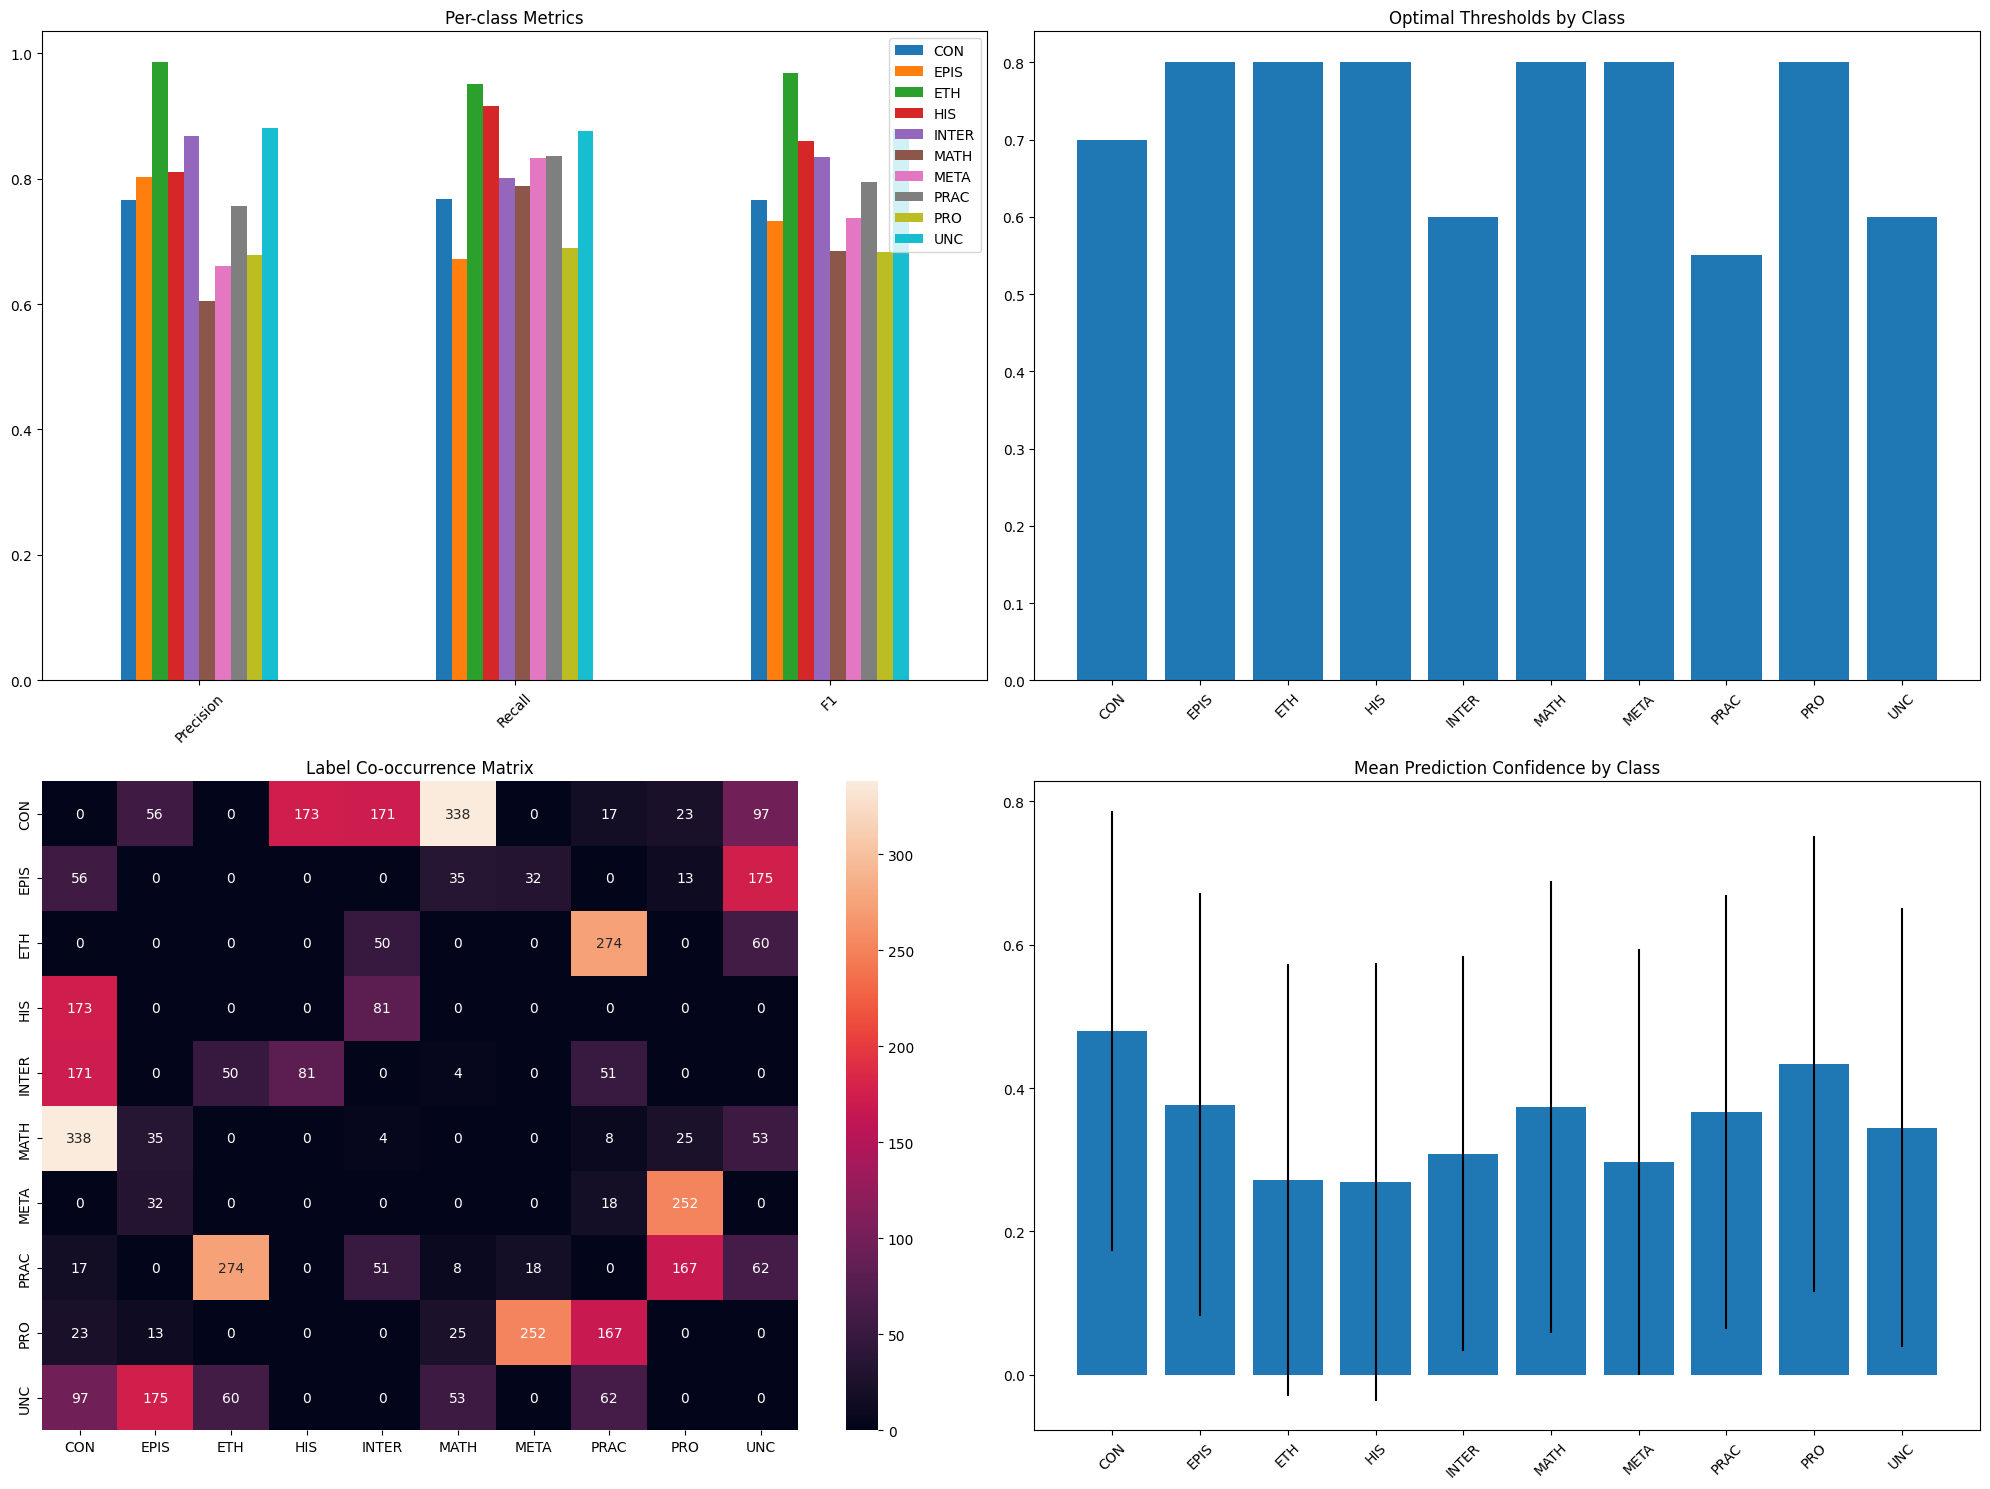

In [ ]:
evaluation_results, probs, preds, labels = evaluate_and_analyze(
    model=model,
    test_loader=test_loader,
    optimal_thresholds=best_thresholds,
    device=device,
    label_names=label_names
)